In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical, Normal

import itertools

import sys
sys.path.insert(0, './../libraries/')

import importance_sample_lib as imp_lib
import galaxy_experiments_lib as galaxy_lib

import sys
sys.path.insert(0, '../../../celeste_net/')
import celeste_net 

from celeste_net import OneGalaxyVAE


from datasets import Synthetic

# Load data

In [2]:
side_len = 31

In [3]:
galaxy_data = Synthetic(side_len, min_galaxies=1, max_galaxies=1, num_bands=5, num_images=100, brightness = 5000)

In [4]:
train_loader, test_loader = galaxy_lib.get_train_test_data(galaxy_data, batch_size=10)

In [5]:
for batch_idx, data in enumerate(train_loader):
    train_data_batch1 = data
    break
    
images_batch1 = train_data_batch1['image']
backgrounds_batch1 = train_data_batch1['background']

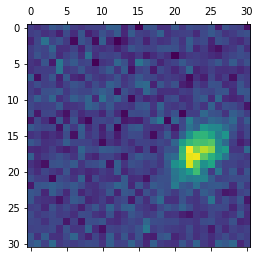

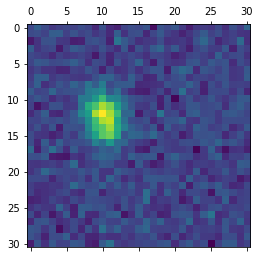

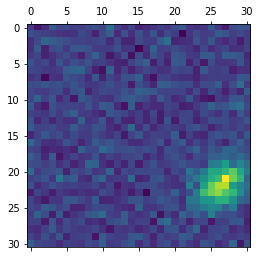

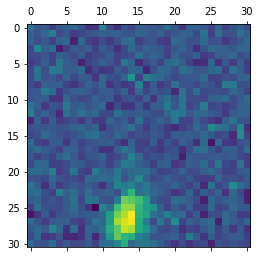

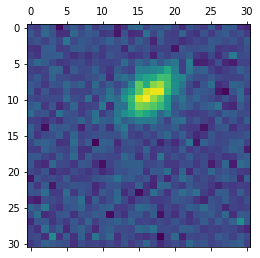

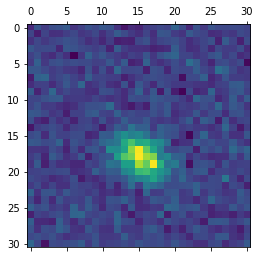

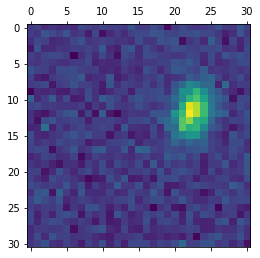

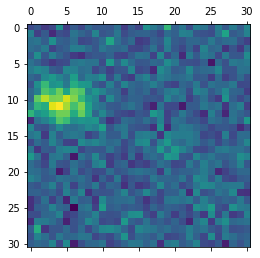

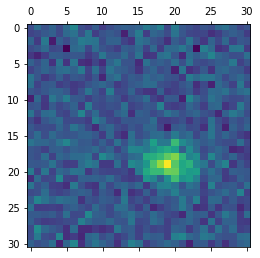

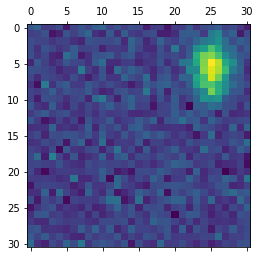

In [6]:
for i in range(images_batch1.shape[0]): 
    plt.matshow(images_batch1[i, 0, :, :])

In [10]:
# The VAE
galaxy_vae = celeste_net.OneGalaxyVAE(side_len)

In [11]:
galaxy_rnn = galaxy_lib.CelesteRNN(side_len, one_galaxy_vae=galaxy_vae)

In [80]:
state_dict = torch.load('../galaxy_results/imp_sampled/galaxy_vae_imp_sampl_off_epoch0.dat', map_location='cpu')
galaxy_rnn.load_state_dict(state_dict, strict = True)

In [81]:
galaxy_rnn.eval(); 
galaxy_rnn.one_galaxy_vae.eval(); 

In [82]:
_, loss = galaxy_rnn.get_pm_loss(image = images_batch1, 
                                    image_so_far = backgrounds_batch1, 
                                    var_so_far = backgrounds_batch1, 
                                    alpha = 0.0, 
                                    topk = 0, 
                                    use_baseline = False)

print(loss)

tensor(1.00000e+05 *
       1.3813)


In [83]:
galaxy_lib.train_epoch(galaxy_rnn, train_loader,
            alpha = 0.0,
            topk = 0,
            use_baseline = False,
            train = False)

tensor(1.00000e+05 *
       1.0265)

In [84]:
pixel_probs = galaxy_rnn.get_pixel_probs(resid_image = images_batch1 - backgrounds_batch1, 
                                         var_so_far = backgrounds_batch1)

In [85]:
torch.max(pixel_probs, dim = 1)

(tensor([ 0.4912,  0.4614,  0.4942,  0.4894,  0.4878,  0.4099,  0.4346,
          0.5000,  0.5012,  0.4853]),
 tensor([ 529,  529,  529,  529,  529,  529,  529,  529,  529,  529]))

In [86]:
prob_off = pixel_probs.detach()[:, -1].view(-1, 1)

prob off:  [0.49422434]


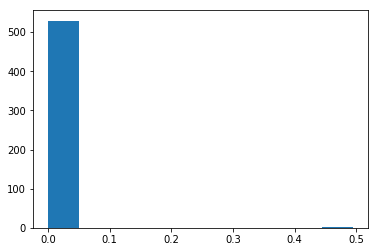

In [87]:
n = 2
plt.hist(pixel_probs[n, :].detach()); 
print('prob off: ', prob_off[n].detach().numpy())

In [88]:
attn_offset = galaxy_rnn.attn_offset

importance_weights = \
    imp_lib.get_importance_weights(torch.abs(images_batch1 - backgrounds_batch1), attn_offset, prob_off)

prob off:  [0.49422434]


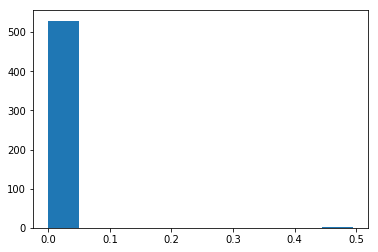

In [89]:
plt.hist(importance_weights[n, :]); 
print('prob off: ', prob_off[n].detach().numpy())

In [90]:
map_pixel_loc = torch.argmax(pixel_probs, dim=1)

In [91]:
cond_loss, recon_mean, recon_var = galaxy_rnn.get_loss_conditional_a(images_batch1 - backgrounds_batch1,
                                                                     backgrounds_batch1, 
                                                                     backgrounds_batch1, 
                                                                     map_pixel_loc)

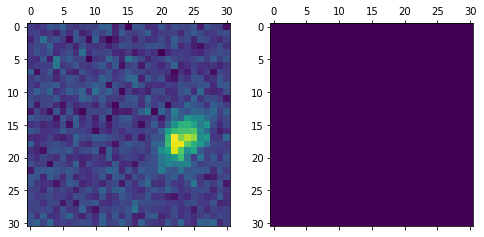

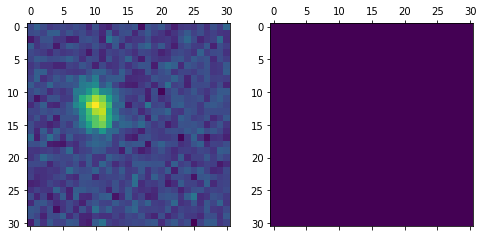

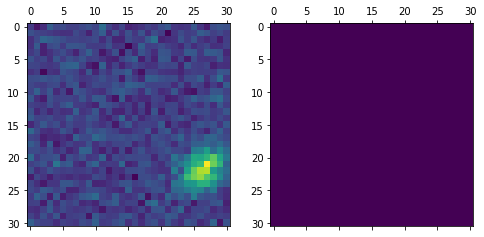

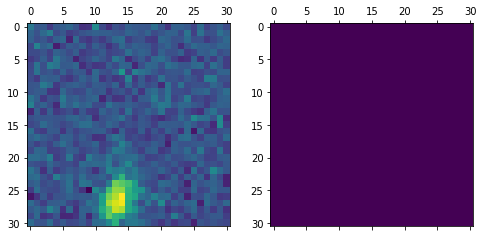

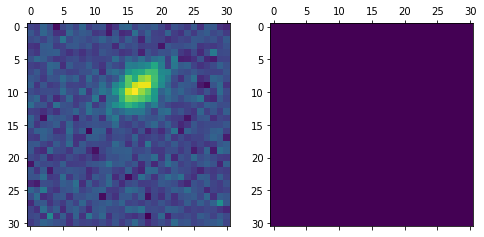

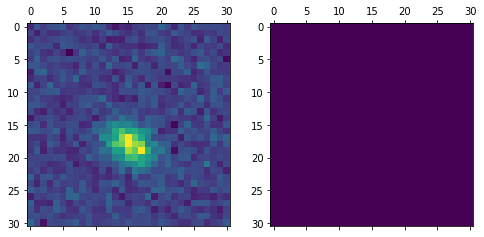

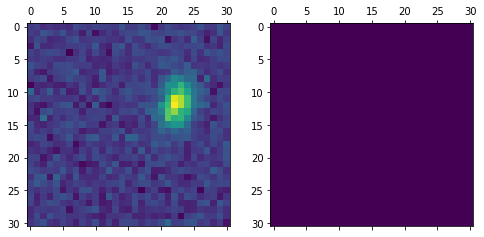

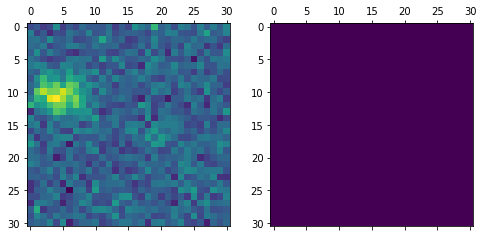

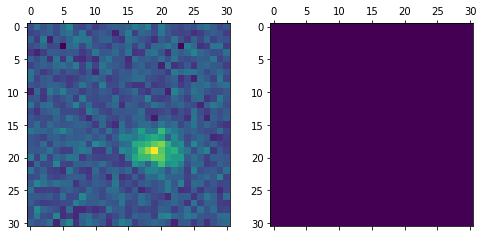

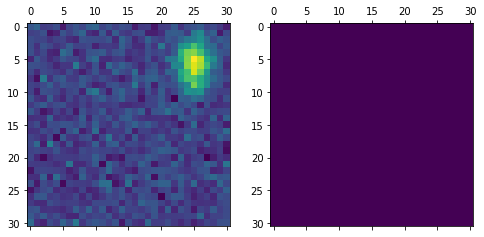

In [92]:
figsize = 8

for n in range(images_batch1.shape[0]): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(images_batch1[n, 0, :, :].squeeze())
    axarr[1].matshow(recon_mean.detach()[n, 0, :, :].squeeze())


In [43]:
loss_array_imp_sample = np.load('../galaxy_results/imp_sampled/galaxy_vae_batch_losses_array.npy')
loss_array_default = np.load('../galaxy_results/imp_sampled/galaxy_vae_imp_sampl_off_batch_losses_array.npy')

In [44]:
fontsize = 18

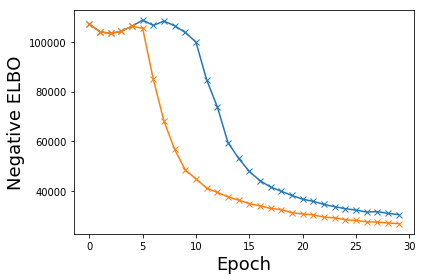

In [47]:
plt.plot(loss_array_imp_sample, '-x')
plt.plot(loss_array_default, '-x')

plt.xlabel('Epoch', fontsize = fontsize)
plt.ylabel('Negative ELBO', fontsize = fontsize)
# plt.legend(('REINFORCE + CV', 'Rao-Blackwellized'))
plt.tight_layout()